In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import scipy.optimize 
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
#Read Data
Salinas = sio.loadmat('Salinas_cube.mat')
HSI = Salinas['salinas_cube'] #Salinas HSI : 220x120x204

ends = sio.loadmat('Salinas_endmembers.mat') # Endmember's matrix: 204x7
endmembers = ends['salinas_endmembers']

In [3]:
#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth= sio.loadmat('Salinas_gt.mat')
labels=ground_truth['salinas_gt']

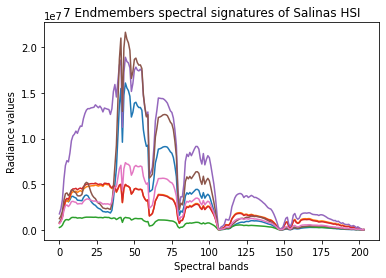

In [4]:
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('7 Endmembers spectral signatures of Salinas HSI')
plt.show()

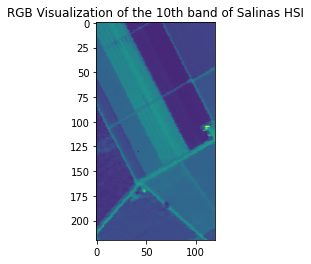

In [5]:
fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Salinas HSI')
plt.show()

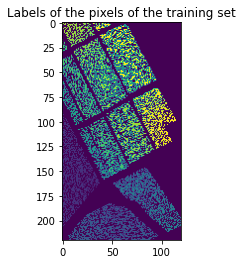

In [6]:
# Trainining set for classification 
Salinas_labels = sio.loadmat('classification_labels_Salinas.mat')
Training_Set = (np.reshape(Salinas_labels['training_set'],(120,220))).T
Test_Set = (np.reshape(Salinas_labels['test_set'],(120,220))).T
Operational_Set = (np.reshape(Salinas_labels['operational_set'],(120,220))).T

fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

## Part 1: Spectral Unmixing 

In [7]:
def abundance_maps(theta):
    fig = plt.subplots(figsize=(12,8))
    maps = np.zeros((220,120,7))
    
    for i in range(0,7):
        maps[np.nonzero(labels)[0], np.nonzero(labels)[1], i] = theta[i, :]
        plt.subplot(3,3,i+1)
        
        plt.imshow(maps[:,:,i])
        plt.colorbar()
    
    return fig 

#### (a) Least Squares

In [8]:
#Keep pixels with nonzero class label
#-- each columns of Y is the spectral signature of one pixel
Y = HSI[~(labels==0)].T
X = endmembers
reconstruction_errors = []
thetas = []

#Repeat loop for every pixel
for i in range(Y.shape[1]):
    
    y = Y[:,i] #one pixel
    theta =  np.linalg.inv(X.T @ X) @ (X.T @ y) #LS Estimator
    thetas.append(theta)
    
    y_est = np.dot(X,theta)
    rec_error = np.linalg.norm(y - y_est)
    reconstruction_errors.append(rec_error)
print(np.mean(reconstruction_errors))

104253152.37160979


(<Figure size 864x576 with 14 Axes>, <AxesSubplot:>)

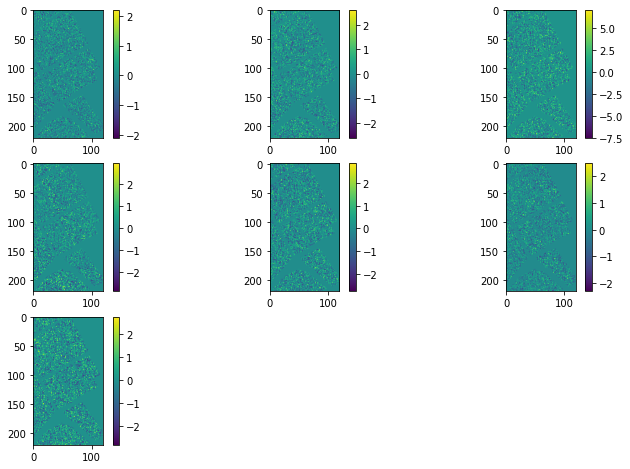

In [9]:
abundance_maps(np.asarray(thetas).T)

The Least Squares method doesn't produce great results for spectral unmixing. Its reconstruction error is too large, and the abundance maps don't offer much information, in comparison to the true labels.

#### (b) Least Squares imposing the sum-to-one constraint

In [10]:
from scipy.optimize import minimize
from scipy.optimize import fmin_slsqp

In [11]:
def objective(theta):
    y = Y[:,i] #one pixel
    y_est = np.dot(X,theta)
    
    mse = (np.square(y - y_est)).mean() #what we need to minimize
    return mse

In [12]:
def sum_to_one(theta):   
    return theta.sum() - 1 #all theta coefficients of every pixel add to one

In [13]:
#Keep pixels with nonzero class label 
#-- each columns of Y is the spectral signature of one pixel
Y = HSI[~(labels==0)].T
X = endmembers
reconstruction_errors = []
theta_est = []

#Repeat loop for every pixel
for i in range(Y.shape[1]):
    
    y = Y[:,i] #one pixel
    x0 = np.zeros(7)
    #LS estimator, all coefficients add to one
    theta = fmin_slsqp(objective, x0=x0 ,f_eqcons=sum_to_one, iprint = 0) 
    theta_est.append(theta)
    
    y_est = np.dot(X,theta)
    
    rec_error = np.linalg.norm(y - y_est)
    reconstruction_errors.append(rec_error)
        
print(np.mean(reconstruction_errors))

166483.96539962225


(<Figure size 864x576 with 14 Axes>, <AxesSubplot:>)

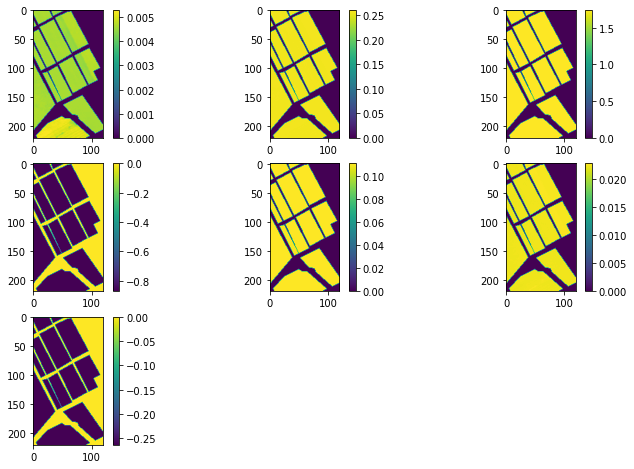

In [14]:
abundance_maps(np.asarray(theta_est).T)

This method's reconstruction error is quite smaller than the Least Squares' one, and the coefficients theta do a much better job in giving information about the image. However, this is still not a good enough method as the materials cannot be distinguished.

#### (c)Least squares imposing the non-negativity constraint on the entries of theta

In [15]:
from scipy.optimize import nnls
#Solve argmin_x || Ax - b ||_2 for x>=0. 
#Xtheta - Y

In [16]:
#Keep pixels with nonzero class label 
#-- each columns of Y is the spectral signature of one pixel
Y = HSI[~(labels==0)].T
X = endmembers
reconstruction_errors = []
theta_est_2 = []

#Repeat loop for every pixel
for i in range(Y.shape[1]):
    
    y = Y[:,i] #one pixel
    #LS Estimator for non-negative values of theta
    theta, rnorm =  nnls(X,Y[:,i]) 
    theta_est_2.append(theta)
    
    y_est = np.dot(X,theta)
    
    rec_error = np.linalg.norm(y - y_est)
    reconstruction_errors.append(rec_error)
print(np.mean(reconstruction_errors))

320.54600527442193


(<Figure size 864x576 with 14 Axes>, <AxesSubplot:>)

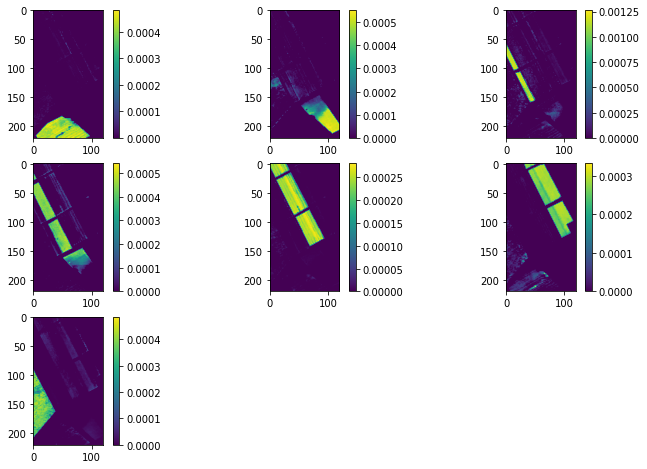

In [17]:
abundance_maps(np.asarray(theta_est_2).T)

In this case, the reconstruction error is much smaller, and the materials are very distinguishable: in each abundance map we are able to tell with great accuracy which material is which.

#### (d) Least squares imposing both the non-negativity and the sum-to-one constraint on the entries of theta

In [18]:
def non_negative(theta):
    theta, rnorm = nnls(X,Y[:,i])
    return theta

In [19]:
x0 = np.zeros(theta.shape)
result = fmin_slsqp(objective, x0=x0 ,eqcons=[sum_to_one, non_negative])

More equality constraints than independent variables    (Exit mode 2)
            Current function value: 5166348.906862745
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1


In [20]:
#Keep pixels with nonzero class label 
#-- each columns of Y is the spectral signature of one pixel
Y = HSI[~(labels==0)].T
X = endmembers
reconstruction_errors = []
theta_est_3 = []

b = (0,math.inf)
bnds = ((b,)*7)

#Repeat loop for every pixel
for i in range(Y.shape[1]):
    
    y = Y[:,i] #one pixel
    x0 = np.zeros(7)
    theta = fmin_slsqp(objective, x0=x0 ,bounds =bnds, f_eqcons=sum_to_one , iprint = 0) 
    theta_est_3.append(theta)
    
    y_est = np.dot(X,theta)
    
    rec_error = np.linalg.norm(y - y_est)
    reconstruction_errors.append(rec_error)
        
print(np.mean(reconstruction_errors))

195584963.54960564


(<Figure size 864x576 with 14 Axes>, <AxesSubplot:>)

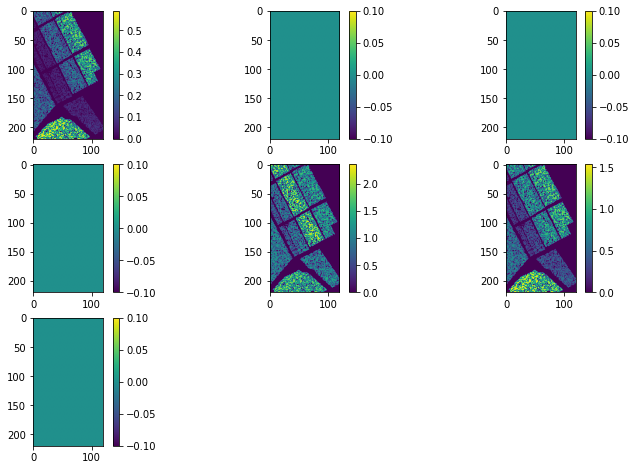

In [21]:
abundance_maps(np.asarray(theta_est_3).T)

This method combines the sum-to-one constraint, which didn't work as well, and the non-negativity constraint, which showed better results. However, its reconstruction error is very big, and some material's coefficients are shrinked to zero. As a result, their abundance maps are empty - they are not giving any information.

#### (e) LASSO

In [22]:
from sklearn import linear_model

In [23]:
clf = linear_model.Lasso(alpha=0.1, fit_intercept=False, normalize=True, tol=1e-2)

In [24]:
clf.fit(X,Y)
thetas = clf.coef_
y_est = clf.predict(X)
rec_error = np.linalg.norm(Y - y_est, axis=0)
np.mean(rec_error)

c:\users\mtsia\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8967548.94374446, tolerance: 3820490.23
  model = cd_fast.enet_coordinate_descent(
c:\users\mtsia\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58195251.568708606, tolerance: 2711512.04
  model = cd_fast.enet_coordinate_descent(


1008.0372638670476

(<Figure size 864x576 with 14 Axes>, <AxesSubplot:>)

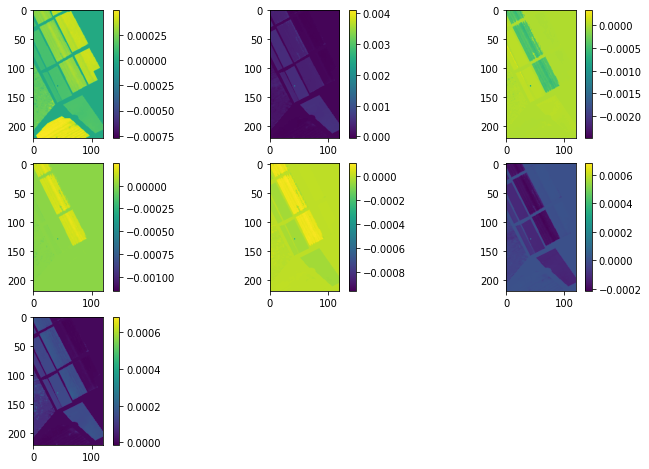

In [25]:
abundance_maps(np.asarray(thetas).T)

Finally, the Lasso method produces a small reconstruction error in comparison to the other methods, and also seems to be able to differentiate between the materials pretty well. Ultimately, this method and the Least Squares imposing the non-negativity constraint one have the best results - each material's placement on the abundance maps coincides with the placements indicated by the image showing the ground truth. 

## Part 2: Classification 

In [7]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

In [8]:
X_train = HSI[(Training_Set!=0)]
y_train = Training_Set[(Training_Set!=0)]
X_test = HSI[(Test_Set!=0)]
y_test = Test_Set[(Test_Set!=0)]
X_operational = HSI[(Operational_Set!=0)]
y_operational = Test_Set[(Operational_Set!=0)]
#these sets contain labels 

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)

In [9]:
#for sklearn models
def model(model):

    clf = model.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=-1)
    
    y_pred = clf.predict(X_test)
    print(f"Mean validation error: {np.mean(1-scores)}\nStandard Deviation of validation error: {np.std(1-scores)}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    print(f"Success Rate = {np.trace(conf_matrix) / sum(map(sum, conf_matrix))}")

In [10]:
#Naive Bayes
model(GaussianNB())

Mean validation error: 0.01831146502326385
Standard Deviation of validation error: 0.004939678071996452
[[545   0   0   0   0   0   3]
 [  5 512   0   0   0   0   0]
 [  0   0 470   0  42   0   0]
 [  0   0   0 210   4   0   0]
 [  0   0  12   4 547   0   0]
 [  1   0   2   0   0 995   0]
 [  6   0   0   0   0   0 874]]
Success Rate = 0.9813327032136105


In [11]:
#KNN Classifier
model(KNeighborsClassifier(n_neighbors=2))

Mean validation error: 0.00519689852378441
Standard Deviation of validation error: 0.002649717593713646
[[548   0   0   0   0   0   0]
 [  0 516   0   0   0   0   1]
 [  0   0 510   0   2   0   0]
 [  0   0   0 214   0   0   0]
 [  0   0   5   1 556   1   0]
 [  0   0   0   0   0 998   0]
 [  2   0   0   0   0   0 878]]
Success Rate = 0.997164461247637


In [12]:
#Bayesian Classifier
model(QuadraticDiscriminantAnalysis())

Mean validation error: 0.029653540098414366
Standard Deviation of validation error: 0.005927139869438801
[[548   0   0   0   0   0   0]
 [  0 517   0   0   0   0   0]
 [  0   0 512   0   0   0   0]
 [  0   0   0 125  89   0   0]
 [  0   0   3   0 558   2   0]
 [  0   0   0   0   0 998   0]
 [  0   0   0   0   0   0 880]]
Success Rate = 0.9777882797731569


In [13]:
def minimum_euclidean(X_train, X_test, y_train):
    
    means = []
    estimated_labels = []

    for i in range(1,8):
    #Mean Estimations-mean of pixels that belong to each label
        mu = np.mean(X_train[y_train==i],0)  
        means.append(mu)
    
    for j in range(X_test.shape[0]): 
        
        distances = []
        for i in range(len(means)):
            dist = np.linalg.norm(X_test[j,:] - means[i]) 
            distances.append(dist) #7 distances
        
        est_label = np.argmin(distances) + 1
        estimated_labels.append(est_label)
    
    return estimated_labels

In [14]:
# KFold validation for Minimum Euclidean Estimator -- only on the train set!
validation_errors = []

for train_index, test_index in k_fold.split(X_train, y_train):
    X_train_kfold = X_train[train_index] 
    X_test_kfold = X_train[test_index] 
    y_train_kfold = y_train[train_index] 
    y_test_kfold = y_train[test_index]
    
    y_pred = minimum_euclidean(X_train_kfold, X_test_kfold, y_train_kfold)

    error = 1 - np.mean(np.asarray(y_pred) == y_test_kfold)
    validation_errors.append(error)

print(f"Mean validation error: {np.mean(validation_errors)}\nStandard Deviation of validation error: {np.std(validation_errors)}")

Mean validation error: 0.044180824548329375
Standard Deviation of validation error: 0.0073339024016856845


In [15]:
#Final Classification
y_pred = minimum_euclidean(X_train, X_test, y_train)
conf_matrix = confusion_matrix(y_test, np.asarray(y_pred))
print(conf_matrix)
print(f"Success Rate = {np.trace(conf_matrix) / sum(map(sum, conf_matrix))}")

[[536   0   4   0   1   0   7]
 [  2 484   0   0   0   0  31]
 [  0   0 417   0  95   0   0]
 [  0   0   0 212   2   0   0]
 [  0   0  16   4 543   0   0]
 [  0   0   6   0   0 992   0]
 [  5   0   0   0   0   0 875]]
Success Rate = 0.9591209829867675


In [16]:
y_pred

[6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 1,
 1,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 3,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 5,
 6,
 6,


All classifiers seem to work very well for our data: The success rate is very high, and according to the confusion matrix, the pixels misclassified are in the worst case (the Minimum Euclidean Distance classifier) 169, only 4% of the total number of pixels used for testing the classifier(4232). Except from the KNN algorithm, which works with great accuracy, the rest of them tend to misclassify material 5: fallow 3, as most non diagonical entries in both row and column 5 of the confusion matrix have the most non-zero entries. In fact, material 5 is the only material that is misclassified in the KNN algorithm.  

### Part 3: 

The classification process is able to deliver much better results in assigning each pixel to its corresponding material, than the spectral unmixing method. Even though each process has different goals: the first method attempts to define the composition of each pixel(how much each material contributes to each pixel's formation) and the second method assigns a single material to every pixel, they can both be used for hyperspectral image processing. Their results do correlate, since the material that contributes the most to the creation of a pixel, is the same as the label of that pixel in the classification method. To be more precise, the processes in Part 1 perform regression tasks and produce probability vectors that correspond to the probability of a pixel containing each material. The processes in Part 2 only give us the label of the material that has the highest probability. 